IMPORTS

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import shutil
import time
import math
import os

plt.ioff()

GLOBAL VARIABLES

In [2]:
START = 'S'  # Start -> nó inicial (canto superior esquerdo)
END = 'E'  # End -> nó final (canto inferior direito)
TERRA = 'T'  # Terra -> movimento para este nó tem custo 1
AGUA = 'A'  # Agua -> movimento para este nó tem custo 3
BARREIRA = 'B'  # Barreira -> can't move here
FRONTEIRA = 'F'  # Fronteira -> can't move here

In [3]:
CSV_ENV_FILE = 'input/sample-environment.csv'
DISPLAY_INTERVAL = 25

CLASSES

In [4]:
class Node:
    def __init__(self, name, pos, cost_so_far, heuristic, path):
        self.name = name
        self.pos = pos
        self.cost_so_far = cost_so_far
        self.heuristic = heuristic
        self.path = path
        self.visited = False
        self.done = False
    
    def __str__(self):
        return f'{self.name} | {self.pos} | {self.cost_so_far} | {self.heuristic} | {self.combined_cost}\n{self.path}'

    def simple_print(self):
        return f'{self.name} - {self.pos} - {self.combined_cost}\n{self.path}'
    
    def __eq__(self, obj):
        return obj.name == self.name and obj.pos == self.pos
    
    @property
    def combined_cost(self):
        return self.cost_so_far + self.heuristic

In [5]:
class Node_Structures:
    def __init__(self, init, grid):
        self.counter = 0
        self.done = []
        self.q = [init]
        self.node_map = {init: Node(grid[0][0], init, 0, 0, [init])}
        for (y, line) in enumerate(grid):
            for (x, _) in enumerate(line):
                if (y, x) != init:
                    pos = (y, x)
                    heuristic = calculate_heuristic_distance_2(*pos, *GOAL)
                    self.node_map[pos] = Node(grid[y][x], pos, 9999, heuristic, [])

    def get_node_from_queue(self, pos):
        return self.node_map[pos]

    def get_graph_map_list(self, path=[]):
        map = [[''] * (MAP_SIZE + 1) for _ in range(MAP_SIZE + 1)]
        for pos in self.node_map:
            if pos in path:
                map[pos[0]][pos[1]] = 'P'
            elif self.node_map[pos].done:
                map[pos[0]][pos[1]] = 'D'
            elif self.node_map[pos].visited:
                map[pos[0]][pos[1]] = 'V'
            else:
                map[pos[0]][pos[1]] = self.node_map[pos].name
        map[MAP_SIZE][MAP_SIZE] = 'E'
        return map

FUNCTIONS

+ Get info from environment file

In [6]:
def read_file(file_name):
    with open(file_name) as fp:
        fp.readline() # ignore first line
        for l in fp.readlines():
            yield l.strip("\n").split(',')[1:]


+ Calculate heuristic

In [7]:
# crashes
def calculate_heuristic_distance(x,y, final_x, final_y):
    dx = abs(x - final_x)
    dy = abs(y - final_y)
    return max(dx, dy)

def calculate_heuristic_distance_2(x,y, final_x, final_y):
    dx = abs(x - final_x)
    dy = abs(y - final_y)
    md = 1 # move distance
    md2 = 2 # move distance 2
    return md * (dx + dy) + (md2 - 2 * md) * min(dx, dy)

# crashes
def calculate_heuristic_distance_3(x,y, final_x, final_y):
    dx = abs(x - final_x)
    dy = abs(y - final_y)
    return 1 * math.sqrt(dx * dx + dy * dy)

+ Get possible move positions

In [8]:
def get_next_moves(x,y):
    return [(x - 1, y - 1), (x - 1, y), (x - 1, y + 1),
            (x, y - 1),                     (x, y + 1),
            (x + 1, y - 1), (x + 1, y), (x + 1, y + 1),]

+ Vizualize environment as map

In [9]:
def visualize_env(map, file_name):
    map_envir = pd.DataFrame(map)
    map_env_num = map_envir.replace(['T', 'A', 'F', 'B', 'S', 'E', 'V', 'D', 'P', 'SP'], [
                                      2,   3,   0,   0,   1,   1,   4,   5,   6,   6])
    f, ax = plt.subplots(figsize=(16, 10))
    ax = sns.heatmap(map_env_num, cmap="mako")
    f.savefig(f'output/{file_name}.png')

+ A* Algorithm

In [10]:
def print_final_path(final_path):
    lines_info = list(read_file(CSV_ENV_FILE))
    grid = np.array(lines_info, dtype=object)
    cost = 0
    for x,y in final_path:
        cost += 3 if grid[x][y] == "A" else 1
        grid[x][y] = 'V'
    print(f"final path's length is {len(final_path)} - costs {cost}")
    visualize_env(grid, '2final_path')

In [11]:
def a_star_algo(node_structures, goal):
    node_map = node_structures.node_map
    q = node_structures.q
    
    node_structures.counter += 1
    if node_structures.counter % DISPLAY_INTERVAL == 0:
        # print(int(node_structures.counter / DISPLAY_INTERVAL))
        visualize_env(node_structures.get_graph_map_list(),
                      f'0map_at_{math.floor(time.time())}_{int(node_structures.counter / DISPLAY_INTERVAL)}')

    h = q.pop(0)
    node_map[h].done = True

    # print("HEAD -> ", node_map[h].simple_print())
    # print('q = [', end='')
    # for (i, n) in enumerate(q):
        # print(f'{node_map[n].pos} [{node_map[n].cost_so_far} + {node_map[n].heuristic} = {node_map[n].combined_cost}]', end=(', ' if i != len(q) - 1 else ']\n'))

    if h == goal:
        print("GG LETS GOOOOOOOOOOOOOOOOOOOOOOOO")
        # print(node_map[h].path)
        visualize_env(node_structures.get_graph_map_list(
            node_map[h].path), '1final_map')
        print_final_path(node_map[h].path)
        return
    
    for x, y in get_next_moves(*h):
        # if move goes outside of map, skip
        if not 0 < x <= MAP_SIZE or not 0 < y <= MAP_SIZE:
            continue

        node = node_map[(x,y)]
        #print(f'{node.pos} actual move -> {node.name not in [FRONTEIRA, BARREIRA] and node.pos not in done}')
        
        # check cost of valid nodes
        if node.name not in [FRONTEIRA, BARREIRA] and not node.done:
            #print(f'{node.name} {node.pos}: {node.cost_so_far} + {node.heuristic} = {node.combined_cost} -> ', end='')
            if node.cost_so_far > (new_cost := node_map[h].cost_so_far + (3 if node.name == AGUA else 1)):
                # change cost and path if new path is better
                node.cost_so_far = new_cost
                node.path = node_map[h].path + [node.pos]
            if not node.visited:
                q.append(node.pos)
                node.visited = True

    node_structures.q = list(set(q)) # remove duplicates
    node_structures.q.sort(key=lambda x: node_map[x].combined_cost)
    a_star_algo(node_structures, goal)

C:\Users\ppdig\AppData\Local\Temp\ipykernel_19144\416760131.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(figsize=(16, 10))


GG LETS GOOOOOOOOOOOOOOOOOOOOOOOO
final path's length is 147 - costs 171


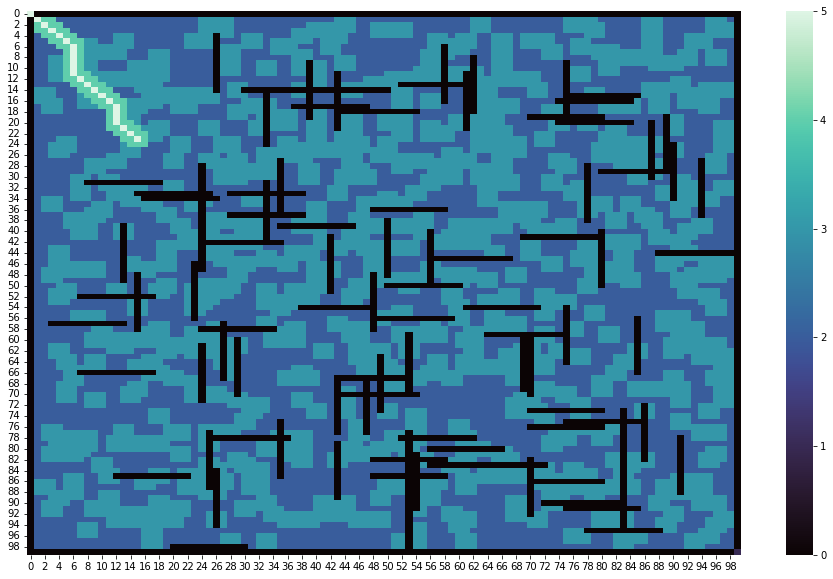

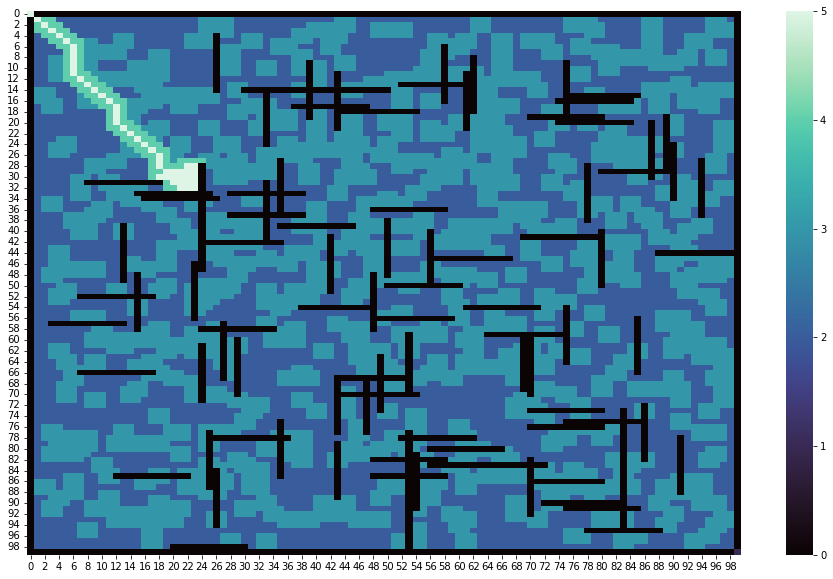

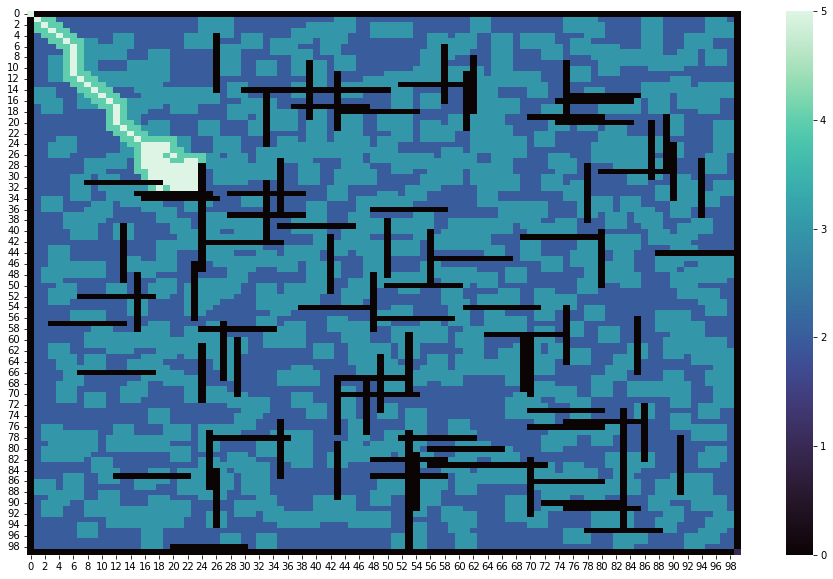

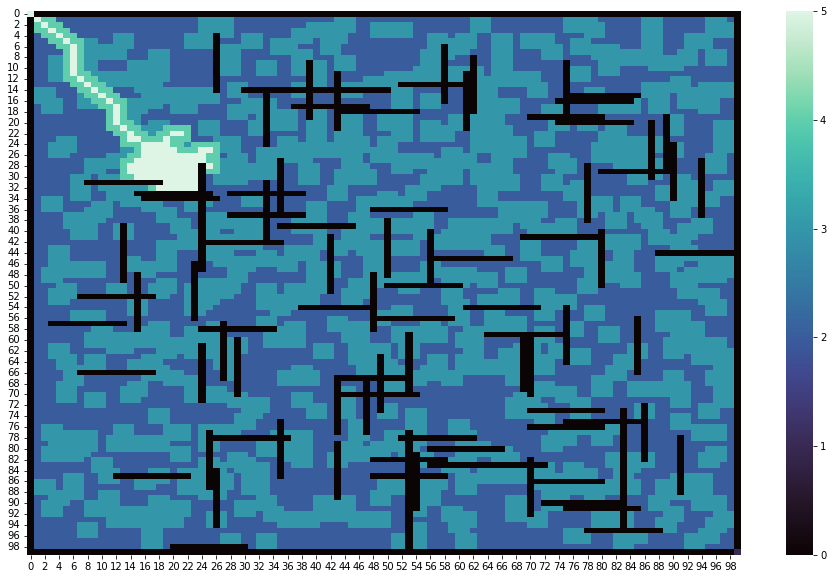

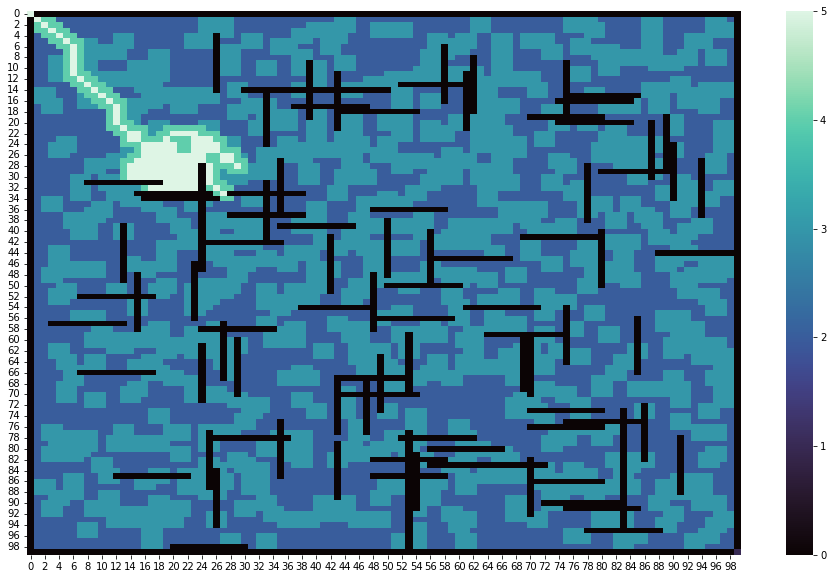

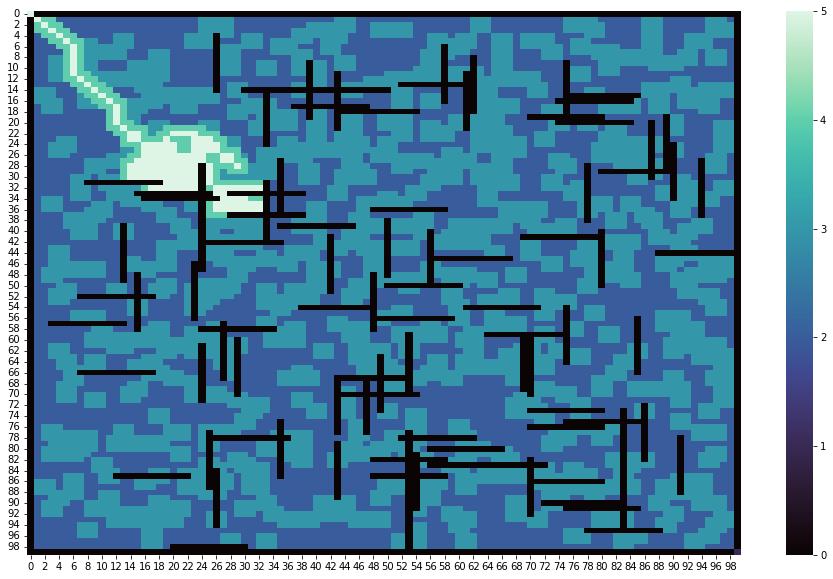

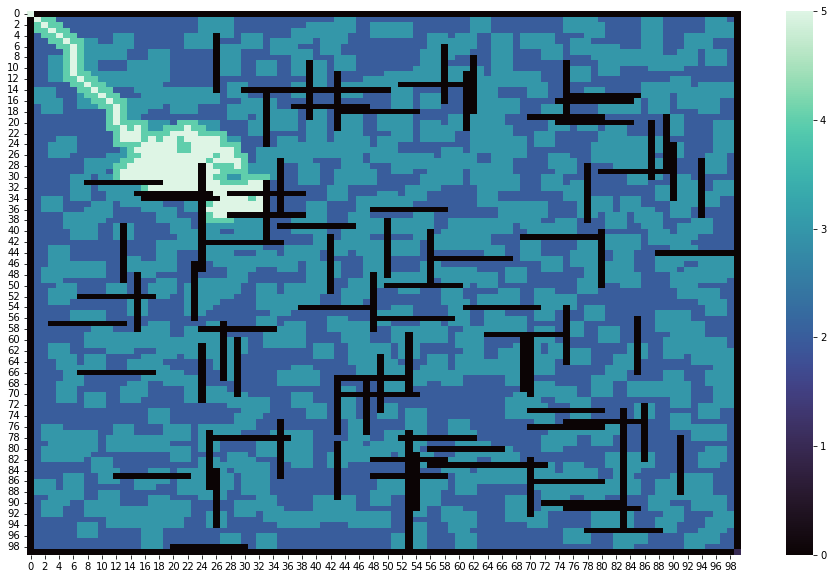

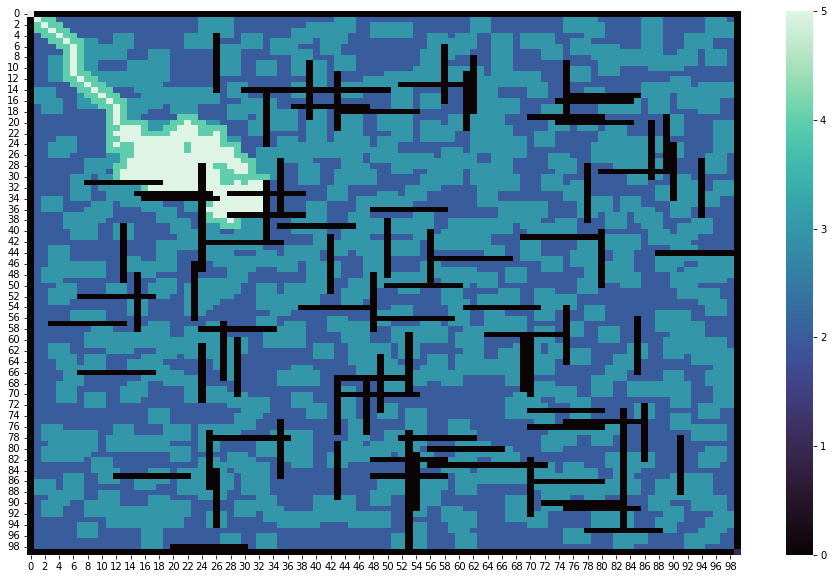

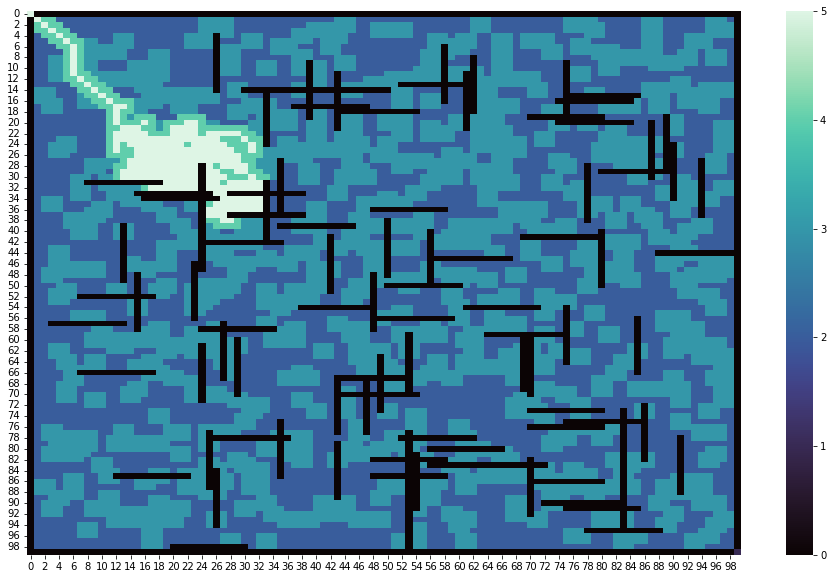

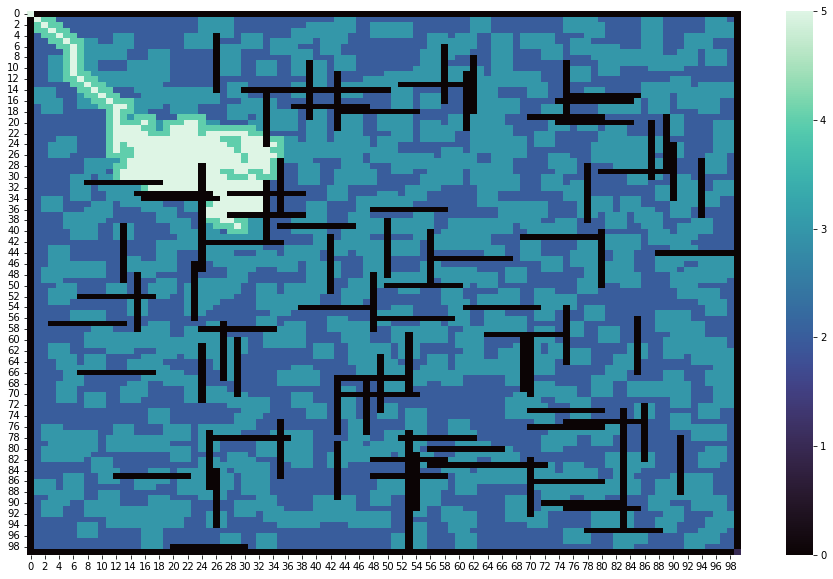

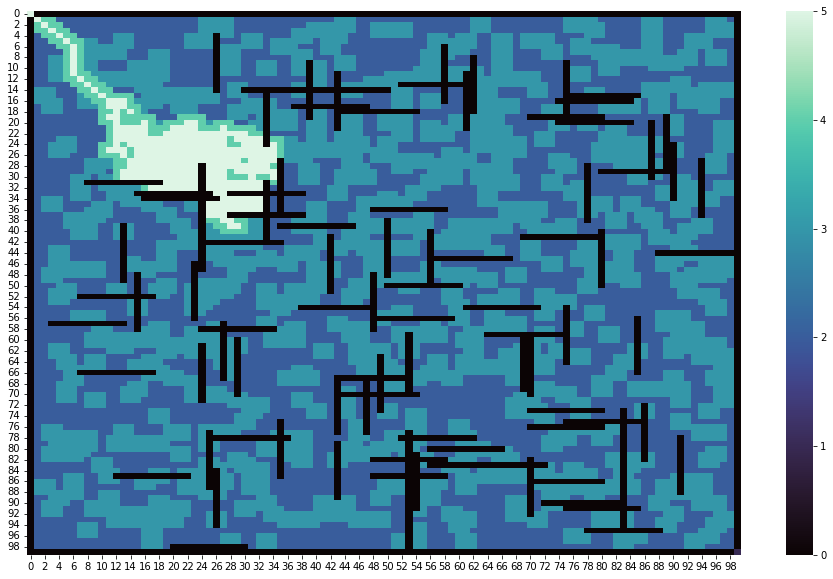

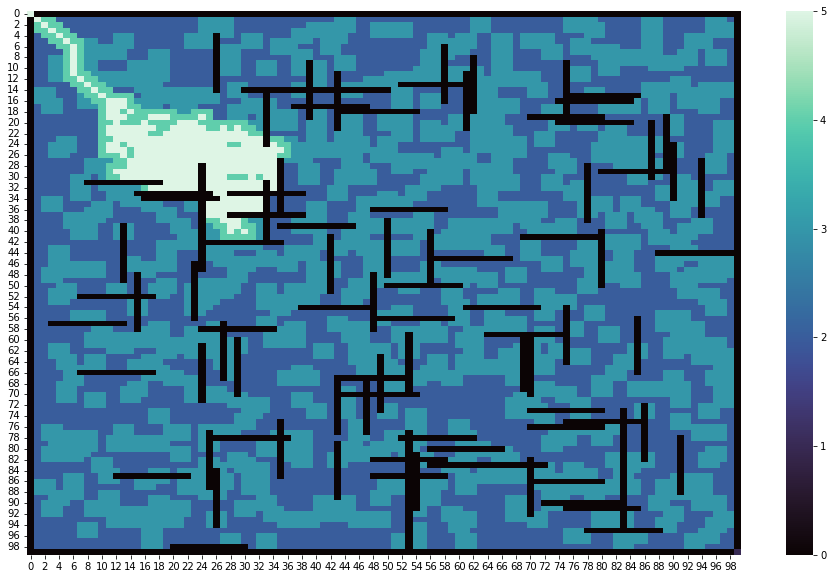

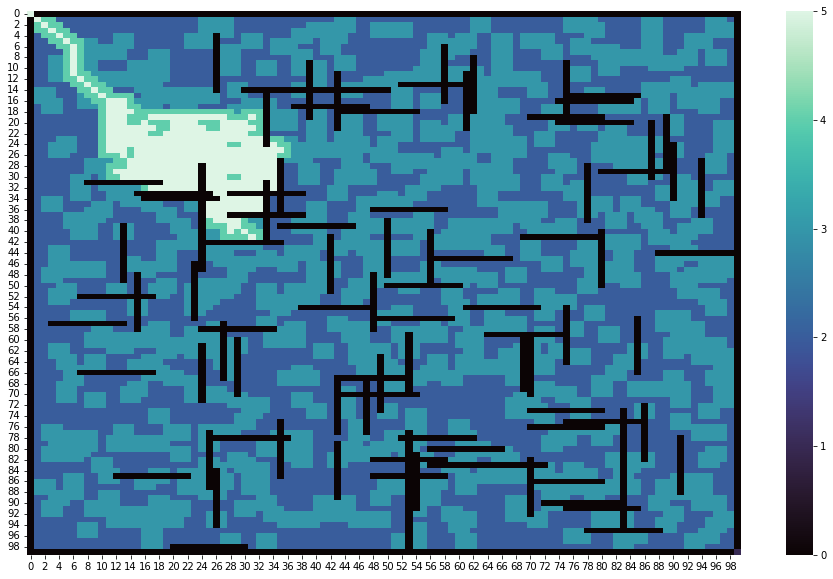

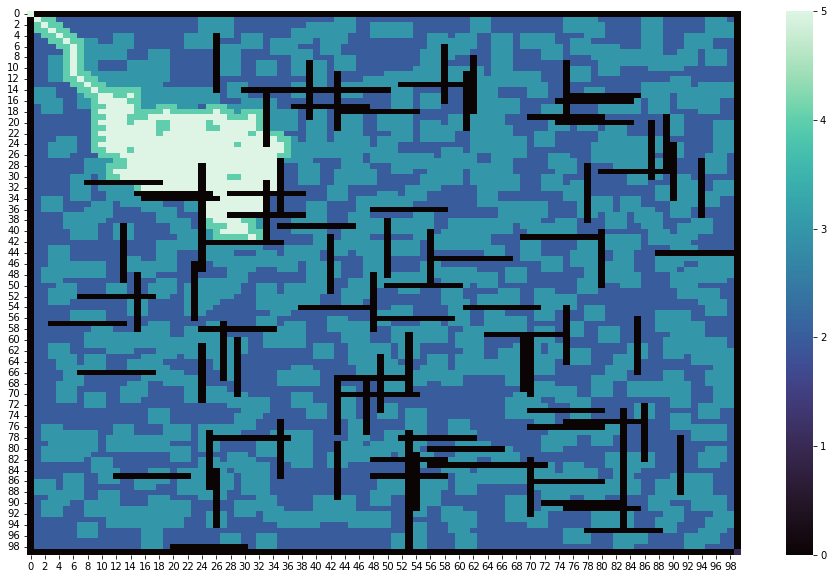

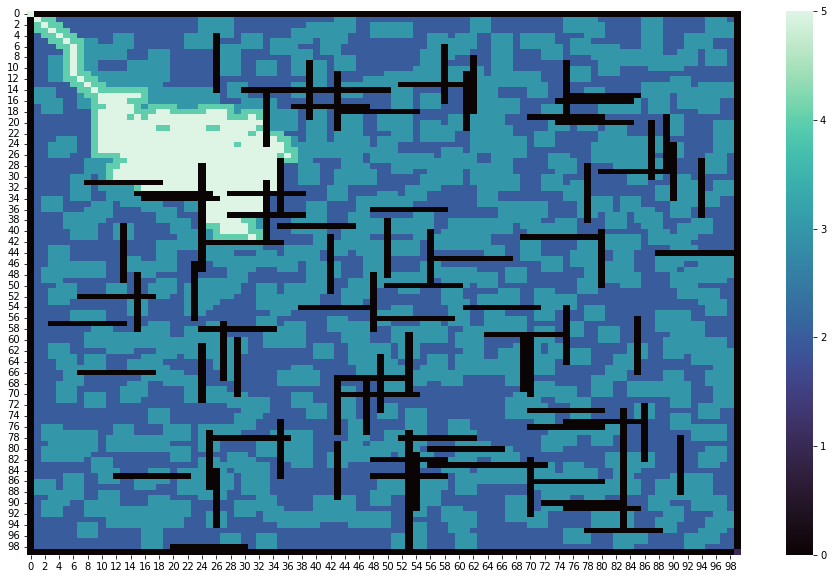

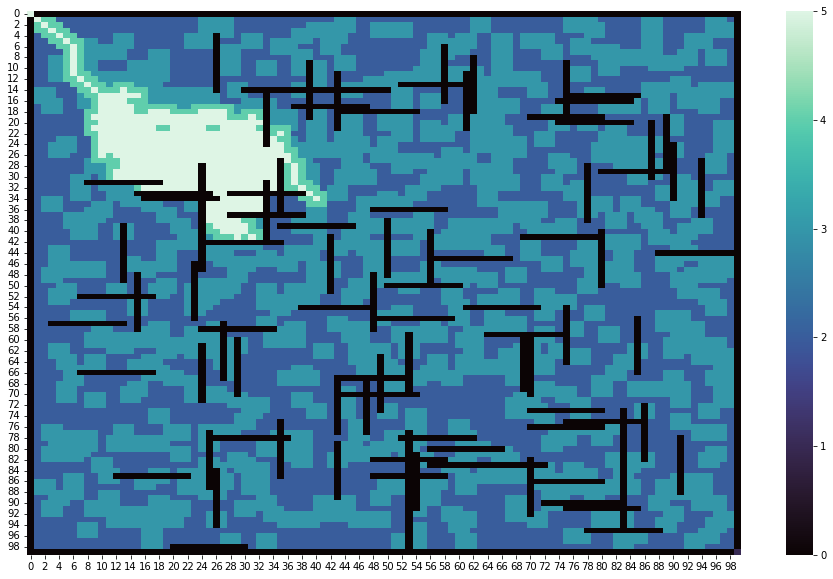

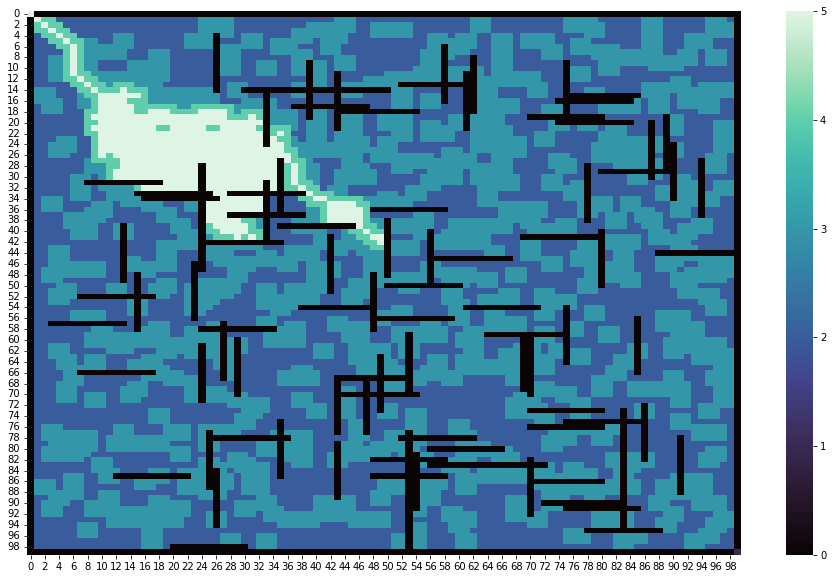

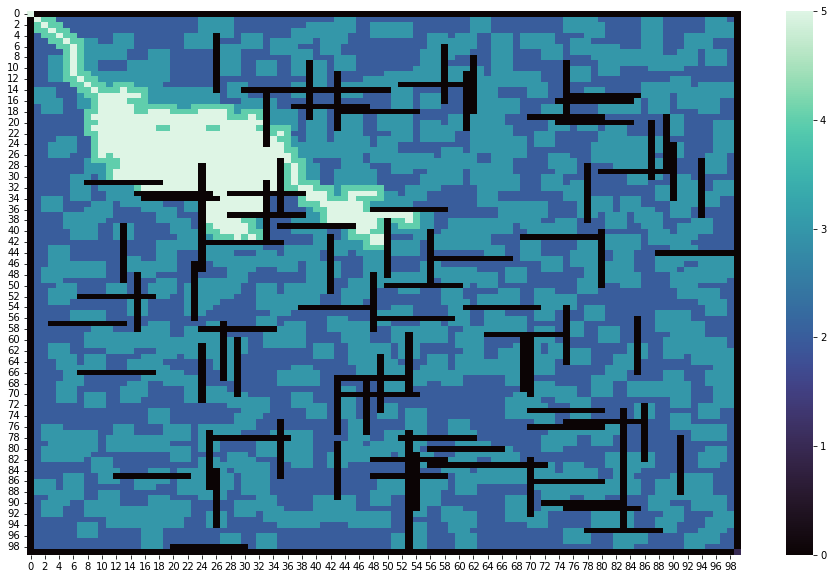

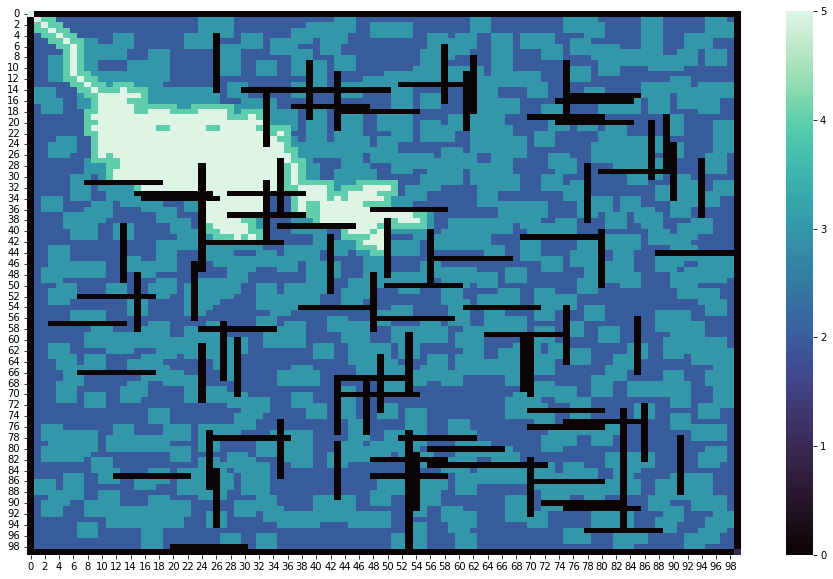

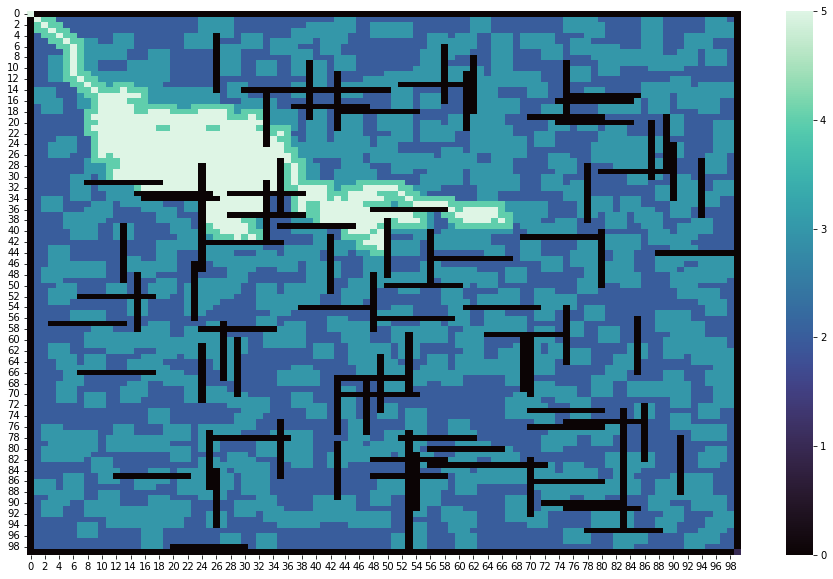

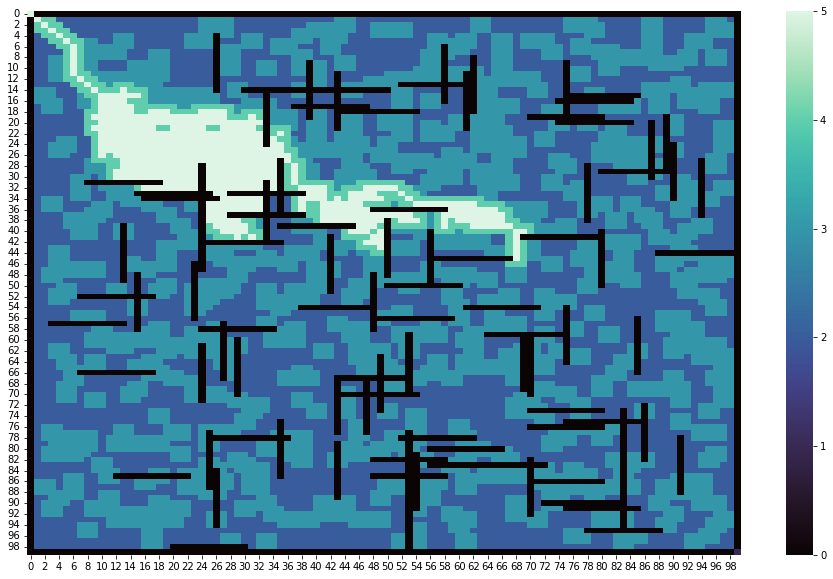

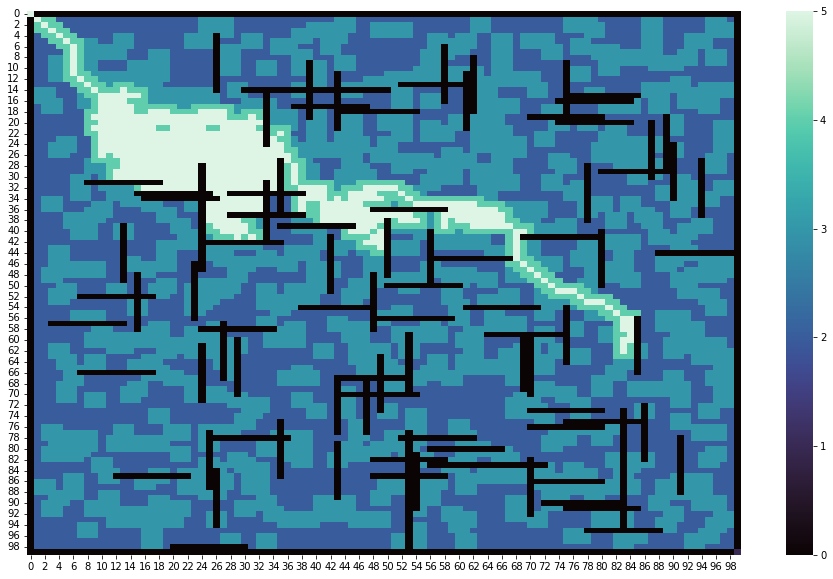

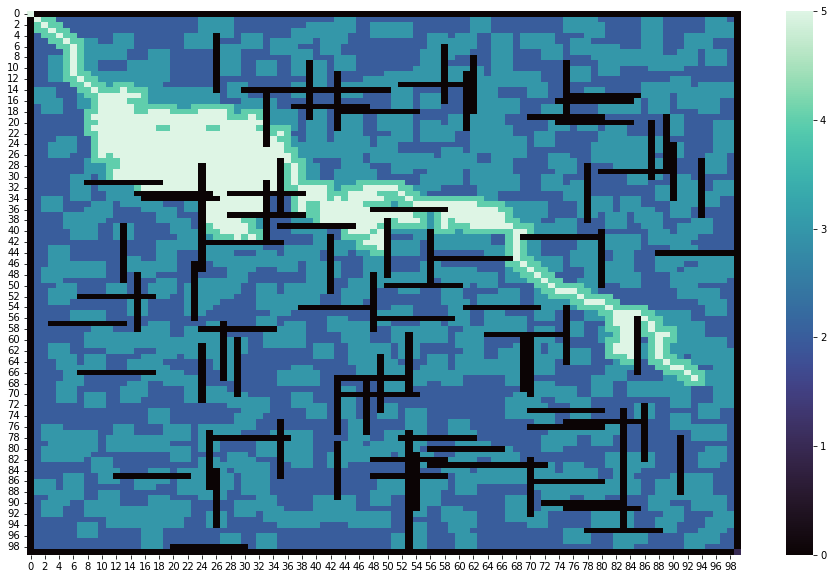

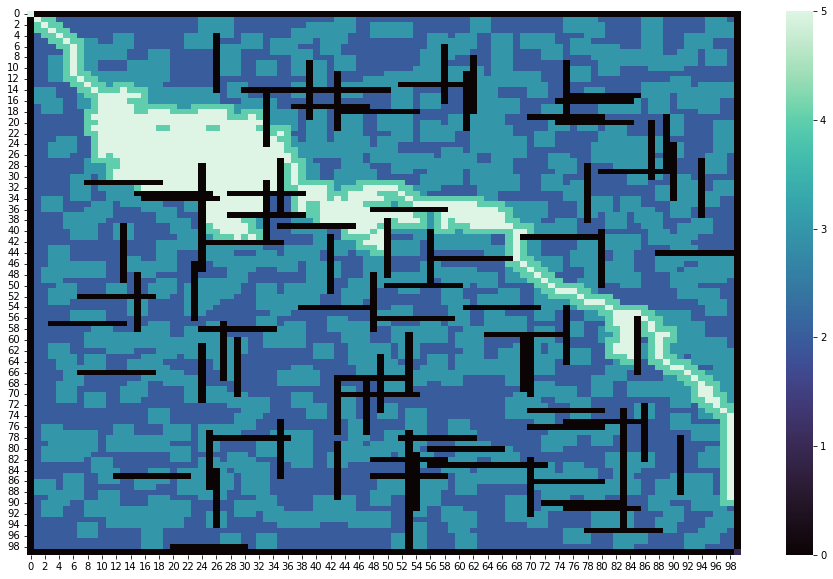

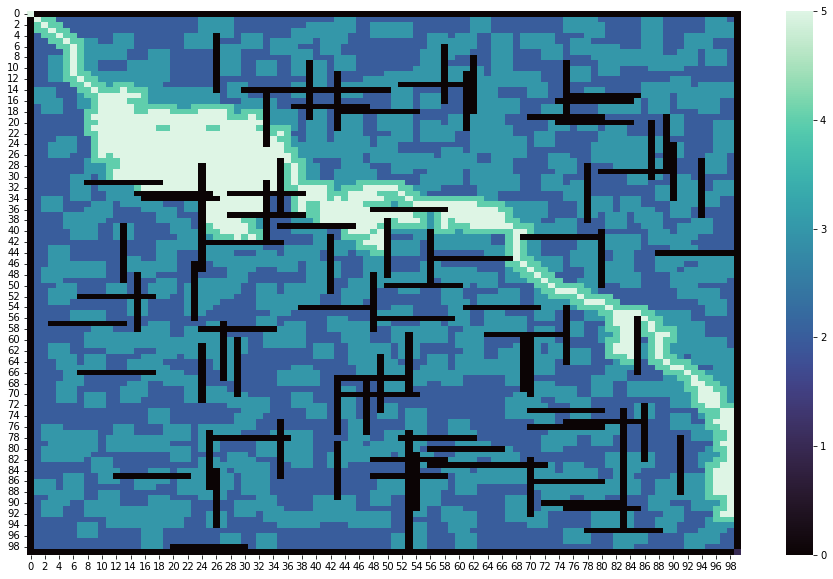

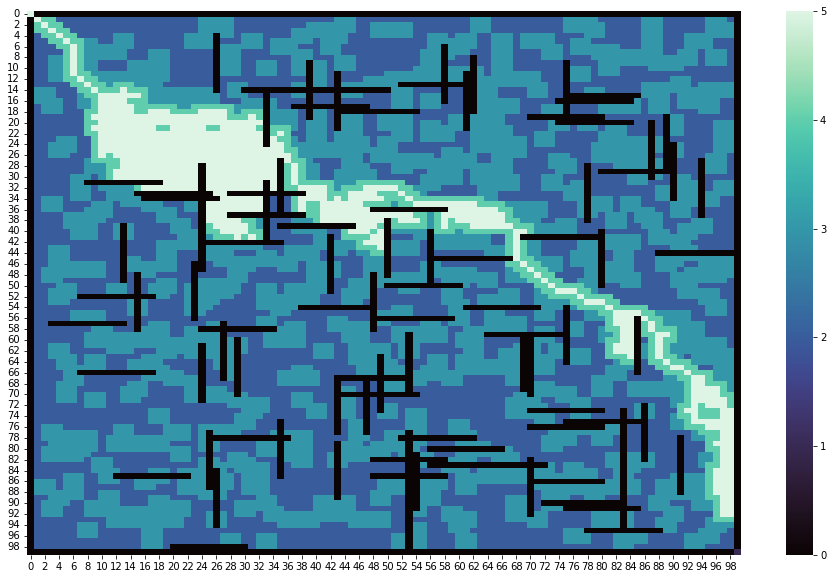

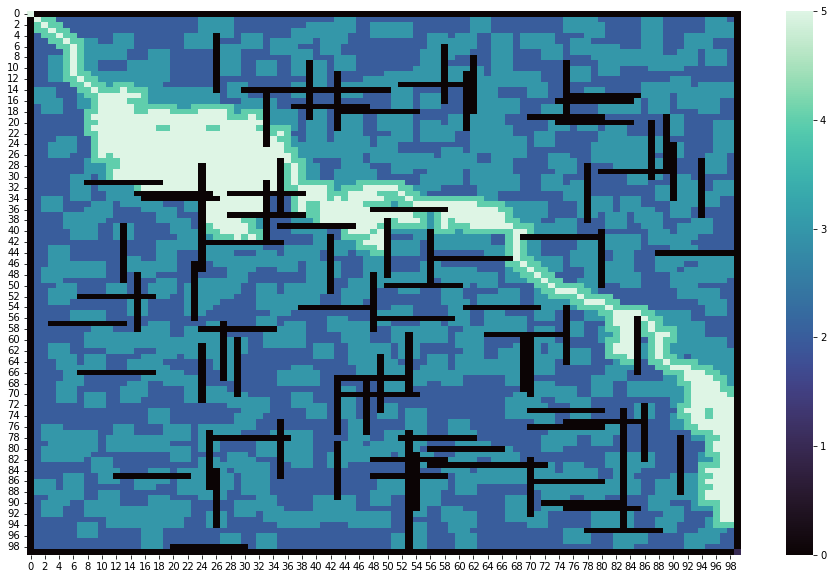

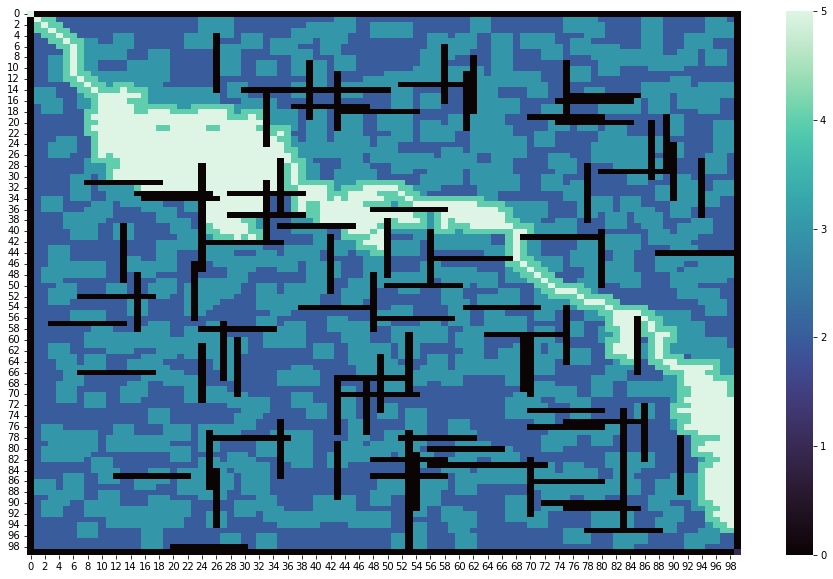

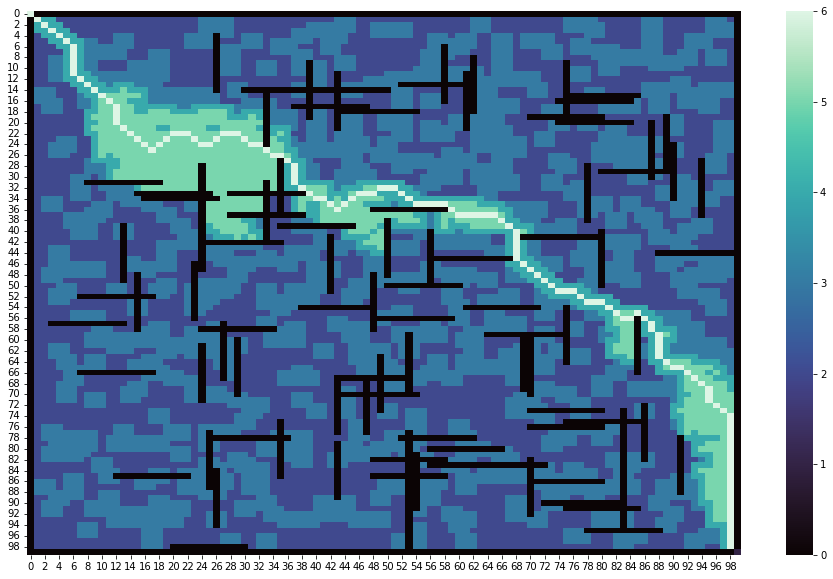

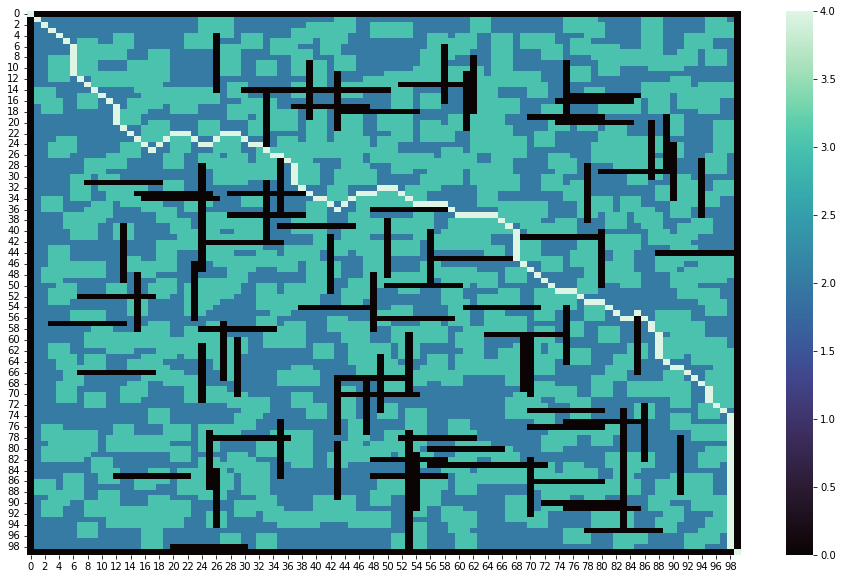

In [12]:

lines_info = list(read_file(CSV_ENV_FILE))
grid = np.array(lines_info, dtype=object)

MAP_SIZE = len(lines_info[0]) - 1
INIT = (0, 0)  # initial state
GOAL = (MAP_SIZE, MAP_SIZE)  # goal state

node_structures = Node_Structures(INIT, grid)

shutil.rmtree('output')
os.makedirs('output')

a_star_algo(node_structures, GOAL)

In [13]:
# start = time.time()
# a_star_algo(node_structures, GOAL)
# end = time.time()
# print(end - start)

In [14]:
import imageio.v2 as imageio

images = []

print()

dir = os.listdir("output")

for filename in dir:
    f = os.getcwd() + "\\output\\" + filename
    if "final_path" in f:
        continue
    if "final_map" in f:
        for _ in range(20):
            images.append(imageio.imread(f))

    images.append(imageio.imread(f))
imageio.mimsave(os.getcwd() + '\\solves\\solve.gif', images, duration=0.15)